### News-Headlines-Dataset-For-Sarcasm-Detection
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

To overcome the limitations related to noise in Twitter datasets, this Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.

##### This new dataset has following advantages over the existing Twitter datasets:

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.
Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.
Unlike tweets which are replies to other tweets, the news headlines we obtained are self-contained. This would help us in teasing apart the real sarcastic elements.
Data

##### Each record consists of three attributes:

is_sarcastic: 1 if the record is sarcastic otherwise 0

headline: the headline of the news article

article_link: link to the original news article. Useful in collecting supplementary data

In [4]:
import tensorflow as tf
import pandas as pd
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import nltk
import sys
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

print(tf.__version__)

2.0.0-alpha0


In [5]:
df = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
df = df[['headline', 'is_sarcastic']]
df.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


#### Exploratory Data Analysis
We would first like to understand the news headline dataset and identify the factors that causes a headline to be sarcastic news report. We would also like to identify if there is an imbalanced class, the frequencies and distribution of the different type of words. This will enable us to know if additional data processing steps are required (e.g. sampling of datapoints from sarcastic class if there is an imbalanced class in the dataset)

#### Data processing steps:

Check for missing values in headline, is_sarcastic

Convert all words into lowercase

Check for imbalanced classes in dataset

Removal of punctuation



##### Some questions we would like to investigate:

What are the frequencies of sarcastic headlines against the non-sarcastic headlines?

What is the word length of headlines? For sarcastic and non-sarcastic headlines?

Does the sarcastic headlines uses statistics (digits/numbers) in their wording? Compared to non-sarcastic headlines

In [6]:
# check for columns with null values
df.is_sarcastic.isnull().any() # no missing values in is_sarcastic column
df.headline.isnull().any() # no missing values in headline column

False

In [8]:
df['headline'] = df.headline.apply(lambda x:x.lower())  # convert all words in headline into lower case 

df['headline'] = df.headline.apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))  # remove all punctuations in headline


In [9]:
df['headline_count'] = df.headline.apply(lambda x: len(list(x.split())))
df['headline_unique_word_count'] = df.headline.apply(lambda x: len(set(x.split())))
df['headline_has_digits'] = df.headline.apply(lambda x: bool(re.search(r'\d', x)))
df

,headline,is_sarcastic,headline_count,headline_unique_word_count,headline_has_digits
0,thirtysomething scientists unveil doomsday clo...,1,8,8,False
1,dem rep totally nails why congress is falling ...,0,13,13,False
2,eat your veggies 9 deliciously different recipes,0,7,7,True
3,inclement weather prevents liar from getting t...,1,8,8,False
4,mother comes pretty close to using word stream...,1,9,9,False
...,...,...,...,...,...
28614,jews to celebrate rosh hashasha or something,1,7,7,False
28615,internal affairs investigator disappointed con...,1,13,12,False
28616,the most beautiful acceptance speech this week...,0,12,12,False
28617,mars probe destroyed by orbiting spielberg-gat...,1,8,8,False


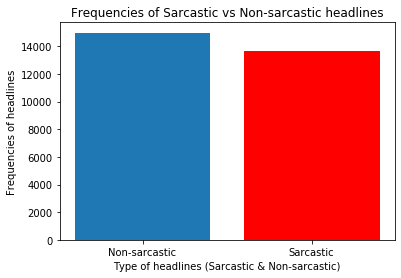

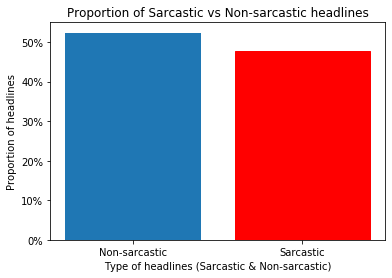

Non-sarcastic    0.52
Sarcastic        0.48
Name: headline_count, dtype: float64

In [10]:
sarcastic_dat = df.groupby('is_sarcastic').count()
sarcastic_dat.index = ['Non-sarcastic','Sarcastic']
plt.xlabel('Type of headlines (Sarcastic & Non-sarcastic)')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Sarcastic vs Non-sarcastic headlines')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline_count)
bar_graph[1].set_color('r')
plt.show()


plt.xlabel('Type of headlines (Sarcastic & Non-sarcastic)')
plt.ylabel('Proportion of headlines')
plt.xticks(fontsize=10)
plt.title('Proportion of Sarcastic vs Non-sarcastic headlines')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline_count / sarcastic_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

# This is not an imbalanced class dataset
# Non-sarcastic    0.56
# Sarcastic        0.44
round(sarcastic_dat.headline_count / sarcastic_dat.headline_count.sum(), 2)

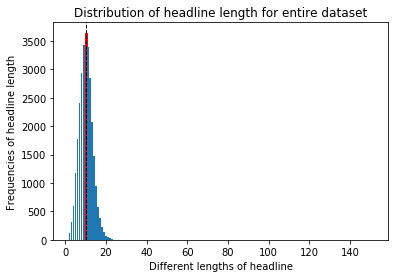

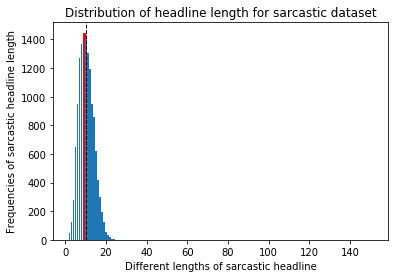

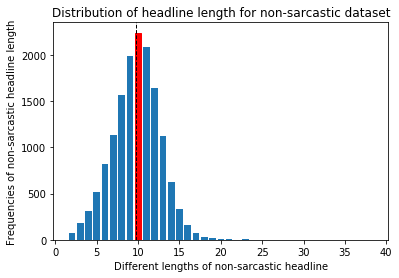

In [11]:
all_dat = df.groupby('headline_count').count()
sarcastic_dat1 = df[df.is_sarcastic==1]
sarcastic_dat = sarcastic_dat1.groupby('headline_count').count()
not_sarcastic_dat1 = df[df.is_sarcastic==0]
not_sarcastic_dat = not_sarcastic_dat1.groupby('headline_count').count()

plt.xlabel('Different lengths of headline')
plt.ylabel('Frequencies of headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for entire dataset')
bar_graph = plt.bar(all_dat.index, all_dat.headline)
bar_graph[8].set_color('r')
plt.axvline(df.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()

plt.xlabel('Different lengths of sarcastic headline')
plt.ylabel('Frequencies of sarcastic headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for sarcastic dataset')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline)
bar_graph[7].set_color('r')
plt.axvline(sarcastic_dat1.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()


plt.xlabel('Different lengths of non-sarcastic headline')
plt.ylabel('Frequencies of non-sarcastic headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for non-sarcastic dataset')
bar_graph = plt.bar(not_sarcastic_dat.index, not_sarcastic_dat.headline)
bar_graph[8].set_color('r')
plt.axvline(not_sarcastic_dat1.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()

# difference in the length of sarcastic and non-sarcastic headlines is not significant. 
# median and mean length of headlines is around 10 words

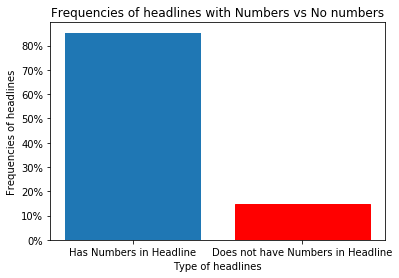

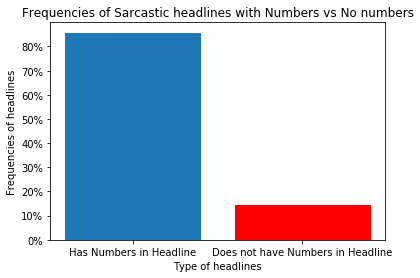

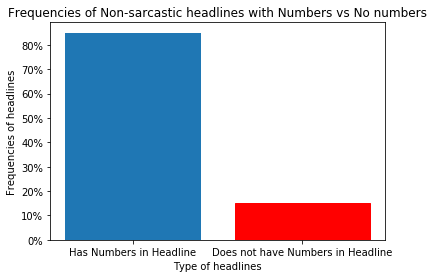

Has Numbers in Headline              0.85
Does not have Numbers in Headline    0.15
Name: headline, dtype: float64
Has Numbers in Headline              0.86
Does not have Numbers in Headline    0.14
Name: headline, dtype: float64
Has Numbers in Headline              0.85
Does not have Numbers in Headline    0.15
Name: headline, dtype: float64


In [12]:
digits_dat = df.groupby('headline_has_digits').count()
digits_dat.index = ['Has Numbers in Headline','Does not have Numbers in Headline']


plt.xlabel('Type of headlines')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of headlines with Numbers vs No numbers')
bar_graph = plt.bar(digits_dat.index, digits_dat.headline / digits_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()


sarcastic_digits_dat = df[df.is_sarcastic==1].groupby('headline_has_digits').count()
sarcastic_digits_dat.index = ['Has Numbers in Headline','Does not have Numbers in Headline']


plt.xlabel('Type of headlines')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Sarcastic headlines with Numbers vs No numbers')
bar_graph = plt.bar(sarcastic_digits_dat.index, sarcastic_digits_dat.headline / sarcastic_digits_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()


not_sarcastic_digits_dat = df[df.is_sarcastic==0].groupby('headline_has_digits').count()
not_sarcastic_digits_dat.index = ['Has Numbers in Headline','Does not have Numbers in Headline']


plt.xlabel('Type of headlines')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Non-sarcastic headlines with Numbers vs No numbers')
bar_graph = plt.bar(not_sarcastic_digits_dat.index, not_sarcastic_digits_dat.headline / not_sarcastic_digits_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

print(round(digits_dat.headline / digits_dat.headline_count.sum(),2))
print(round(sarcastic_digits_dat.headline / sarcastic_digits_dat.headline_count.sum(),2))
print(round(not_sarcastic_digits_dat.headline / not_sarcastic_digits_dat.headline_count.sum(),2))

# difference in the use of numbers/statistics in sarcastic and non-sarcastic headlines is not significant. 
# ~85% headlines uses numbers

#### Conclusion of insights from EDA:
What are the frequencies of sarcastic headlines against the non-sarcastic headlines?
This is not an imbalanced class dataset. 56% of the headlines are non-sarcastic and 44% of the headlines are sarcastic. Hence, there is no requirements for conduct sampling to ensure an equal proportion of datasets from each class.

What is the word length of headlines? 
For sarcastic and non-sarcastic headlines?

In the entire dataset, the mean and median length of headlines is around 10 words. There are some headlines with 2 / 3 / 4 words. These headlines need to be removed as they are too short. Short headlines will have a higher likelihood of being similar to other headlines without providing meaningful information in the topics.

There is no significant difference in the length of headlines for sarcastic and non-sarcastic datatset

Does the sarcastic headlines uses statistics (digits/numbers) in their wording? Compared to non-sarcastic headlines?
In the entire dataset, 85% $$$$$ of all the headlines uses numbers. There is no significant difference in the use of numbers for sarcastic and non-sarcastic datatset. This suggests that most headlines uses numbers to attract viewership.

### Prediction of Sarcasm in headlines using Deep Learning methods
For the prediction of sarcasm of headlines, we will use RNN with the following architectures:

##### RNN with Gated Recurrent Units (with Lasso Regularization, Dropout, Batch Normalization)
##### RNN with Gated Recurrent Units (with Ridge Regularization, Dropout, Batch Normalization)
##### RNN with Long Short Term Memory Units (with Lasso Regularization, Dropout, Batch Normalization)
##### RNN with Long Short Term Memory Units (with Ridge Regularization, Dropout, Batch Normalization)
##### CNN with Conv1D
    Output from CNN with Conv1D is used as input for RNN with LSTM (with Lasso Regularization, Dropout, Batch Normalization)



#### RNN with GRU

In [13]:
train_data, test_data = train_test_split(df[['headline', 'is_sarcastic']], test_size=0.1)  # randomly splitting 10% of dataset to be training dataset 

training_sentences = list(train_data['headline'])
training_labels = list(train_data['is_sarcastic'])

testing_sentences = list(test_data['headline'])
testing_labels = list(test_data['is_sarcastic'])
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [14]:
vocab_size = 10000   # limit vector of words to the top 10,000 words
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

# no lemmatization, removal of stop words and stemming of headlines as we would like to maintain the syntax, literature integrity, sequence of words in LSTM.

In [15]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [16]:
# Model Definition with BiRNN (GRU)
# with L1 Lasso Regularization, for feature selection
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
batch_normalization_v2 (Batc (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 176,601
Trainable params: 176,401
Non-trainable params: 200
________________________________________________

In [17]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Train on 25757 samples, validate on 2862 samples
Epoch 1/10
25757/25757 [==============================] - 46s 2ms/sample - loss: 0.8418 - accuracy: 0.7806 - val_loss: 0.5092 - val_accuracy: 0.8428
Epoch 2/10
25757/25757 [==============================] - 36s 1ms/sample - loss: 0.2978 - accuracy: 0.8968 - val_loss: 0.3824 - val_accuracy: 0.8438
Epoch 3/10
25757/25757 [==============================] - 37s 1ms/sample - loss: 0.2241 - accuracy: 0.9314 - val_loss: 0.3924 - val_accuracy: 0.8539
Epoch 4/10
25757/25757 [==============================] - 35s 1ms/sample - loss: 0.1605 - accuracy: 0.9539 - val_loss: 0.5007 - val_accuracy: 0.8305
Epoch 5/10
25757/25757 [==============================] - 34s 1ms/sample - loss: 0.1273 - accuracy: 0.9661 - val_loss: 0.5086 - val_accuracy: 0.8424
Epoch 6/10
25757/25757 [==============================] - 35s 1ms/sample - loss: 0.0988 - accuracy: 0.9778 - val_loss: 0.6066 - val_accuracy: 0.8389
Epoch 7/10
25757/25757 [==============================] -

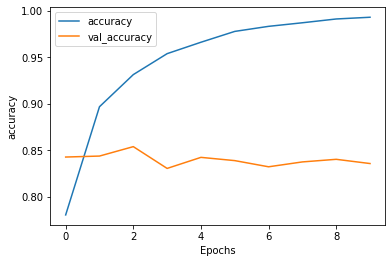

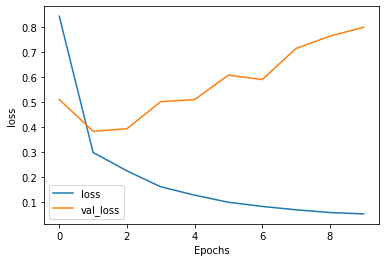

In [18]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

In [19]:
# Model Definition with BiRNN (GRU)
# with L2 Ridge Regularization
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               6500      
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 176,601
Trainable params: 176,401
Non-trainable params: 200
______________________________________________

In [20]:
epoch = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Train on 25757 samples, validate on 2862 samples
Epoch 1/10
25757/25757 [==============================] - 37s 1ms/sample - loss: 0.5033 - accuracy: 0.7879 - val_loss: 0.4589 - val_accuracy: 0.8365
Epoch 2/10
25757/25757 [==============================] - 32s 1ms/sample - loss: 0.2650 - accuracy: 0.8981 - val_loss: 1.4685 - val_accuracy: 0.5940
Epoch 3/10
25757/25757 [==============================] - 32s 1ms/sample - loss: 0.1792 - accuracy: 0.9347 - val_loss: 0.6593 - val_accuracy: 0.7907
Epoch 4/10
25757/25757 [==============================] - 33s 1ms/sample - loss: 0.1343 - accuracy: 0.9531 - val_loss: 0.4099 - val_accuracy: 0.8470
Epoch 5/10
25757/25757 [==============================] - 33s 1ms/sample - loss: 0.0997 - accuracy: 0.9680 - val_loss: 0.9113 - val_accuracy: 0.7771
Epoch 6/10
25757/25757 [==============================] - 33s 1ms/sample - loss: 0.0786 - accuracy: 0.9755 - val_loss: 0.6654 - val_accuracy: 0.8295
Epoch 7/10
25757/25757 [==============================] -

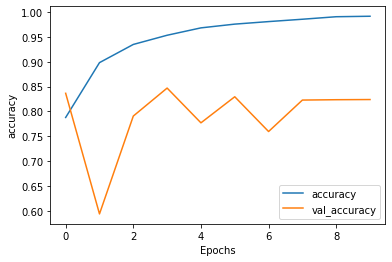

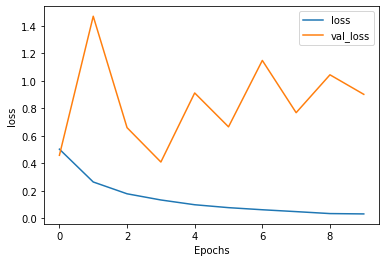

In [21]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

#### RNN with LSTM Architecture
For the prediction of sarcasm of headlines, we will use RNN with the following architectures:

RNN with Long Short Term Memory Units (with Lasso Regularization, Dropout, Batch Normalization)
RNN with Long Short Term Memory Units (with Ridge Regularization, Dropout, Batch Normalization)

In [22]:
# Model Definition with BiRNN (LSTM)
# with L1 Lasso Regularization, for feature selection
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               6500      
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, 100)               400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 179,545
Trainable params: 179,345
Non-trainable params: 200
______________________________________________

In [23]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Train on 25757 samples, validate on 2862 samples
Epoch 1/10
25757/25757 [==============================] - 33s 1ms/sample - loss: 0.7976 - accuracy: 0.8020 - val_loss: 0.5044 - val_accuracy: 0.8581
Epoch 2/10
25757/25757 [==============================] - 33s 1ms/sample - loss: 0.2888 - accuracy: 0.9005 - val_loss: 0.3670 - val_accuracy: 0.8526
Epoch 3/10
25757/25757 [==============================] - 36s 1ms/sample - loss: 0.2170 - accuracy: 0.9309 - val_loss: 0.6174 - val_accuracy: 0.7851
Epoch 4/10
25757/25757 [==============================] - 38s 1ms/sample - loss: 0.1695 - accuracy: 0.9504 - val_loss: 0.4508 - val_accuracy: 0.8501
Epoch 5/10
25757/25757 [==============================] - 38s 1ms/sample - loss: 0.1340 - accuracy: 0.9649 - val_loss: 0.4853 - val_accuracy: 0.8536
Epoch 6/10
25757/25757 [==============================] - 34s 1ms/sample - loss: 0.1056 - accuracy: 0.9751 - val_loss: 0.6040 - val_accuracy: 0.8428
Epoch 7/10
25757/25757 [==============================] -

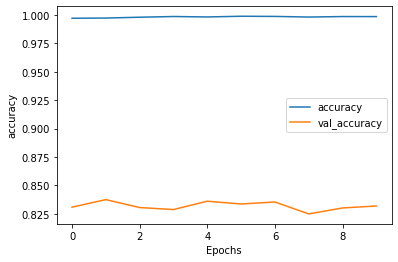

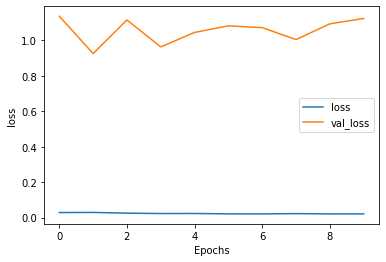

In [26]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

In [27]:
# Model Definition with BiRNN (LSTM)
# with L2 Ridge Regularization
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               6500      
_________________________________________________________________
batch_normalization_v2_3 (Ba (None, 100)               400       
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 179,545
Trainable params: 179,345
Non-trainable params: 200
______________________________________________

In [24]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Train on 25757 samples, validate on 2862 samples
Epoch 1/10
25757/25757 [==============================] - 30s 1ms/sample - loss: 0.0495 - accuracy: 0.9931 - val_loss: 0.7270 - val_accuracy: 0.8417
Epoch 2/10
25757/25757 [==============================] - 31s 1ms/sample - loss: 0.0446 - accuracy: 0.9941 - val_loss: 0.8617 - val_accuracy: 0.8379
Epoch 3/10
25757/25757 [==============================] - 31s 1ms/sample - loss: 0.0726 - accuracy: 0.9867 - val_loss: 0.8367 - val_accuracy: 0.8368
Epoch 4/10
25757/25757 [==============================] - 30s 1ms/sample - loss: 0.0502 - accuracy: 0.9924 - val_loss: 0.8952 - val_accuracy: 0.8407
Epoch 5/10
25757/25757 [==============================] - 31s 1ms/sample - loss: 0.0387 - accuracy: 0.9951 - val_loss: 0.8984 - val_accuracy: 0.8354
Epoch 6/10
25757/25757 [==============================] - 32s 1ms/sample - loss: 0.0359 - accuracy: 0.9960 - val_loss: 0.8933 - val_accuracy: 0.8340
Epoch 7/10
25757/25757 [==============================] -

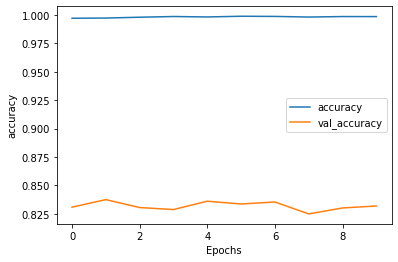

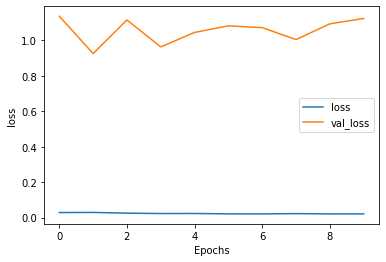

In [28]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

In [29]:
# Model Definition with CNN (Conv1D)
# with L1 Lasso Regularization, for feature selection
# Dropout, for robustness
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               12900     
_________________________________________________________________
batch_normalization_v2_4 (Ba (None, 100)               400       
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [30]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Train on 25757 samples, validate on 2862 samples
Epoch 1/10
25757/25757 [==============================] - 15s 588us/sample - loss: 0.9432 - accuracy: 0.7844 - val_loss: 0.8591 - val_accuracy: 0.5395
Epoch 2/10
25757/25757 [==============================] - 14s 554us/sample - loss: 0.3364 - accuracy: 0.8880 - val_loss: 5.0320 - val_accuracy: 0.5377
Epoch 3/10
25757/25757 [==============================] - 12s 452us/sample - loss: 0.2733 - accuracy: 0.9140 - val_loss: 0.4235 - val_accuracy: 0.8347
Epoch 4/10
25757/25757 [==============================] - 12s 478us/sample - loss: 0.2459 - accuracy: 0.9264 - val_loss: 1.9968 - val_accuracy: 0.5898
Epoch 5/10
25757/25757 [==============================] - 14s 536us/sample - loss: 0.2256 - accuracy: 0.9336 - val_loss: 0.8187 - val_accuracy: 0.7250
Epoch 6/10
25757/25757 [==============================] - 13s 515us/sample - loss: 0.2112 - accuracy: 0.9388 - val_loss: 0.4818 - val_accuracy: 0.8305
Epoch 7/10
25757/25757 [=====================

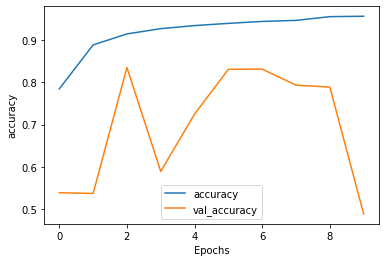

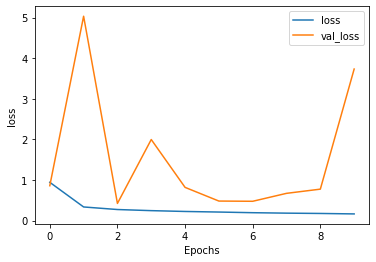

In [31]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

#### CNN
For the prediction of sarcasm of headlines, we will use CNN with the following architectures:

CNN with Conv1D

In [32]:
# Model Definition with CNN (Conv1D)
# with L2 Ridge Regularization
# Dropout, for robustness
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 183,369
Trainable params: 183,369
Non-trainable params: 0
________________________________________________

In [33]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))


Train on 25757 samples, validate on 2862 samples
Epoch 1/10
25757/25757 [==============================] - 12s 461us/sample - loss: 0.6288 - accuracy: 0.6792 - val_loss: 0.4474 - val_accuracy: 0.8120
Epoch 2/10
25757/25757 [==============================] - 10s 385us/sample - loss: 0.3686 - accuracy: 0.8636 - val_loss: 0.3850 - val_accuracy: 0.8470
Epoch 3/10
25757/25757 [==============================] - 11s 421us/sample - loss: 0.3038 - accuracy: 0.8972 - val_loss: 0.3725 - val_accuracy: 0.8498
Epoch 4/10
25757/25757 [==============================] - 11s 430us/sample - loss: 0.2641 - accuracy: 0.9176 - val_loss: 0.3836 - val_accuracy: 0.8463
Epoch 5/10
25757/25757 [==============================] - 10s 399us/sample - loss: 0.2374 - accuracy: 0.9290 - val_loss: 0.3907 - val_accuracy: 0.8470
Epoch 6/10
25757/25757 [==============================] - 11s 425us/sample - loss: 0.2157 - accuracy: 0.9387 - val_loss: 0.3931 - val_accuracy: 0.8466
Epoch 7/10
25757/25757 [=====================

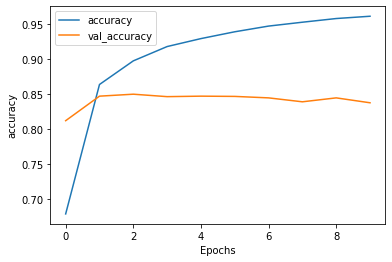

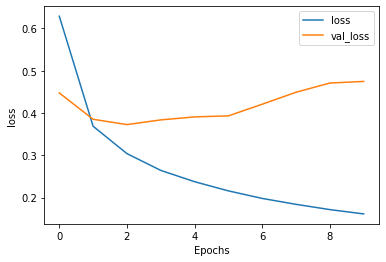

In [36]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

##### CNN-RNN combined architecture
For the prediction of sarcasm of headlines, we will use the following architecture:

Combination of CNN-RNN (LSTM)
Output from CNN with Conv1D is used as input for RNN with LSTM (with Lasso Regularization, Dropout)

In [34]:
# Model Definition with CNN (Conv1D)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 1, activation='relu'),
    tf.keras.layers.MaxPooling1D(2, padding="same"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.005), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.005), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 120, 128)          2176      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60, 128)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               6500      
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

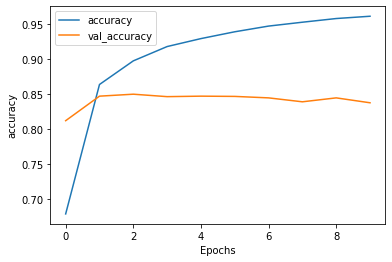

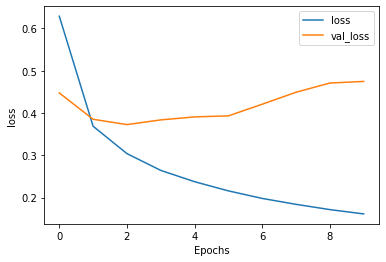

In [35]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()